In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Aggregate transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',        # Total spending
    'TransactionID': 'count',   # Number of transactions
    'Quantity': 'sum'           # Total quantity purchased
}).reset_index()

# Merge aggregated data with customer profiles
customer_data = customers.merge(customer_transactions, on='CustomerID')

# Display the merged data
print(customer_data.head())


  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   TransactionID  Quantity  
0              5        12  
1              4        10  
2              4        14  
3              8        23  
4              3         7  


In [5]:
# Select features for clustering
features = customer_data[['TotalValue', 'TransactionID', 'Quantity']]  # Numerical features
features_scaled = StandardScaler().fit_transform(features)  # Standardize the data

# Display the scaled features
print(pd.DataFrame(features_scaled, columns=features.columns).head())


   TotalValue  TransactionID  Quantity
0   -0.061701      -0.011458 -0.122033
1   -0.877744      -0.467494 -0.448000
2   -0.405857      -0.467494  0.203934
3    1.032547       1.356650  1.670787
4   -0.783929      -0.923530 -0.936951


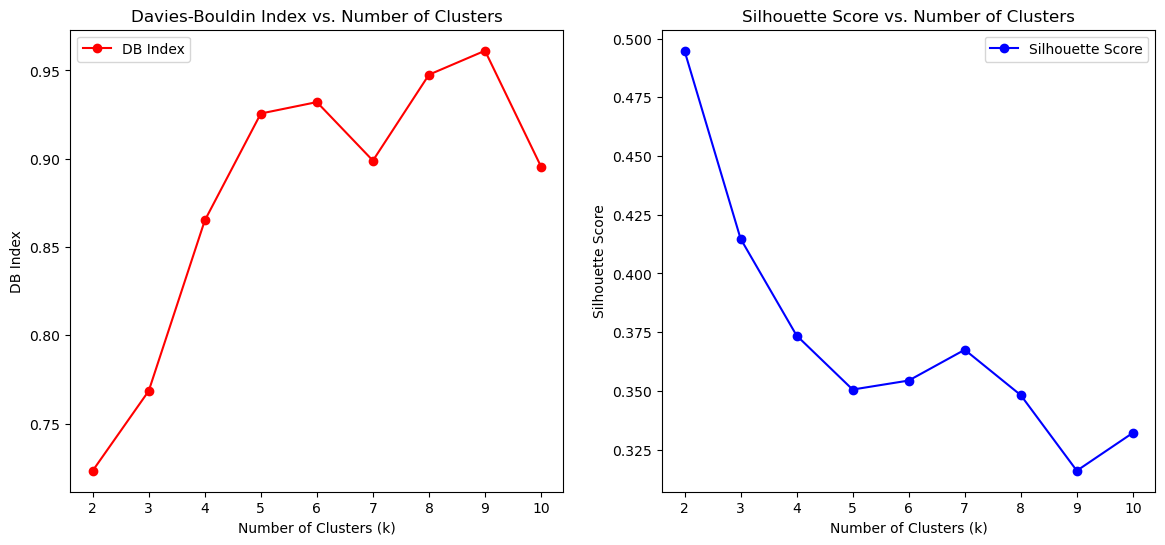

In [7]:
db_scores = []  # Davies-Bouldin Index
silhouette_scores = []  # Silhouette Scores
inertia_scores = []  # KMeans inertia (sum of squared distances)

for k in range(2, 11):  # Number of clusters (2 to 10)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    
    # Compute metrics
    labels = kmeans.labels_
    db_scores.append(davies_bouldin_score(features_scaled, labels))
    silhouette_scores.append(silhouette_score(features_scaled, labels))
    inertia_scores.append(kmeans.inertia_)

# Plot DB Index and Silhouette Score to find the optimal k
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_scores, marker='o', color='r', label='DB Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='b', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.legend()

plt.show()


In [9]:
# Choose the optimal number of clusters (based on the DB Index/Silhouette analysis)
optimal_k = 3  # Update this based on the plots above

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data['Cluster'] = kmeans.fit_predict(features_scaled)

# Display cluster assignments
print(customer_data[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        2
1      C0002        1
2      C0003        2
3      C0004        0
4      C0005        1


In [11]:
# Calculate DB Index
db_index = davies_bouldin_score(features_scaled, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_scaled, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Inertia (sum of squared distances)
print(f"Inertia: {kmeans.inertia_}")


Davies-Bouldin Index: 0.7685569688730741
Silhouette Score: 0.4148217825177174
Inertia: 151.5897986633089


In [13]:
from sklearn.decomposition import PCA

# Reduce features to 2D for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

# Add 2D coordinates to the dataset
customer_data['PCA1'] = features_2d[:, 0]
customer_data['PCA2'] = features_2d[:, 1]


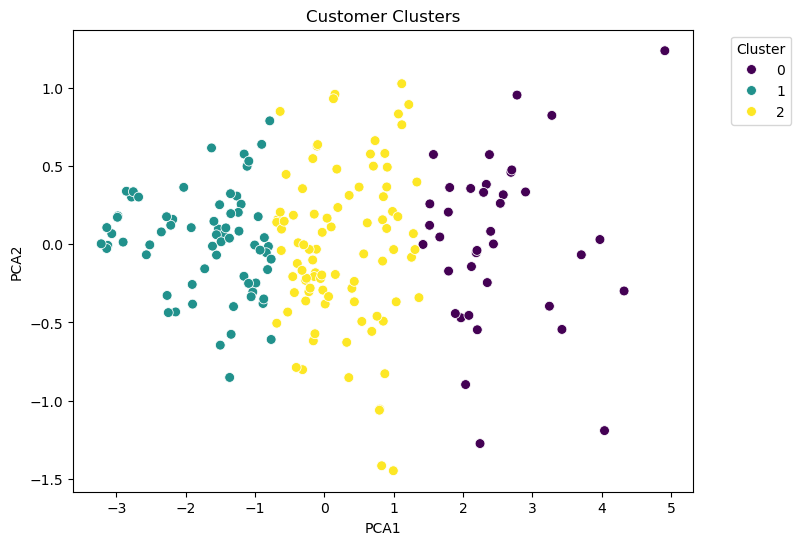

In [15]:
# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=customer_data,
    x='PCA1', y='PCA2',
    hue='Cluster', palette='viridis',
    s=50
)
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [17]:
# Save the clustering results
customer_data.to_csv('FirstName_LastName_Clustering.csv', index=False)

# Display clustering results
print(customer_data[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        2
1      C0002        1
2      C0003        2
3      C0004        0
4      C0005        1
